# EfficientNet (Efficient scaling for image classification)

https://arxiv.org/pdf/1905.11946.pdf

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/



## Description
* EfficientNet is a family of convolutional neural networks that scales up in a more structured way to achieve higher accuracy and efficiency.
* Varies by version (B0-B7), but B0 has around 237 layers.


| Base model       | Resolution |
|------------------|------------|
| EfficientNetB0   | 224        |
| EfficientNetB1   | 240        |
| EfficientNetB2   | 260        |
| EfficientNetB3   | 300        |
| EfficientNetB4   | 380        |
| EfficientNetB5   | 456        |
| EfficientNetB6   | 528        |
| EfficientNetB7   | 600        |

* ~8.4M for EfficientNet-B0 (the base model).
* Compound scaling method - scaling the depth, width, and resolution of the network in a balanced way.
* It is available in PyTorch through libraries like torchvision or third-party implementations.

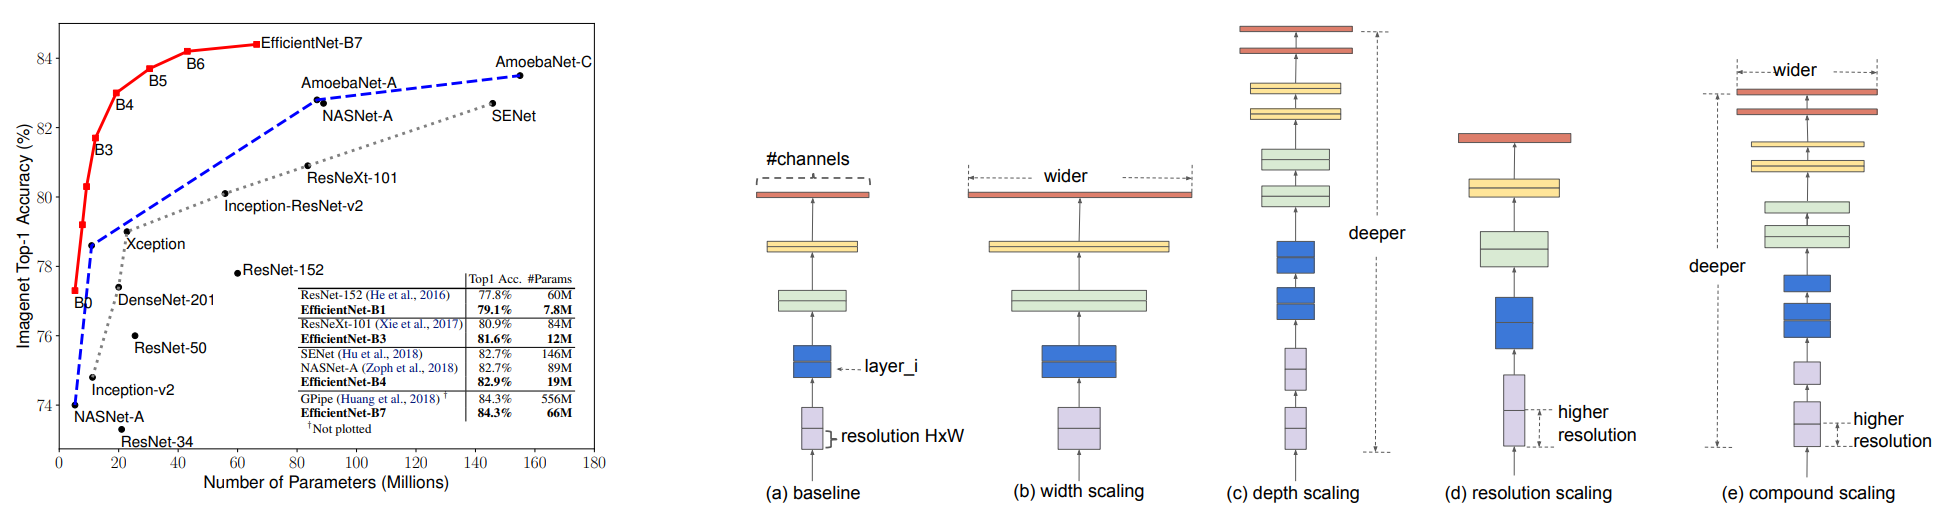

## Squeeze-and-excitation optimization

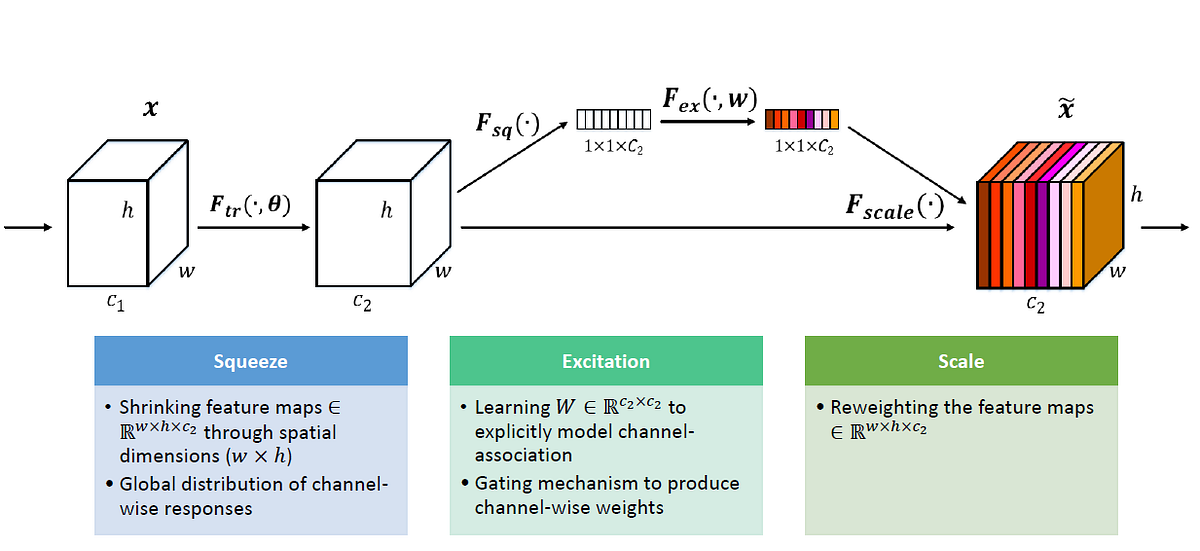

## Inverted bottleneck MBConv

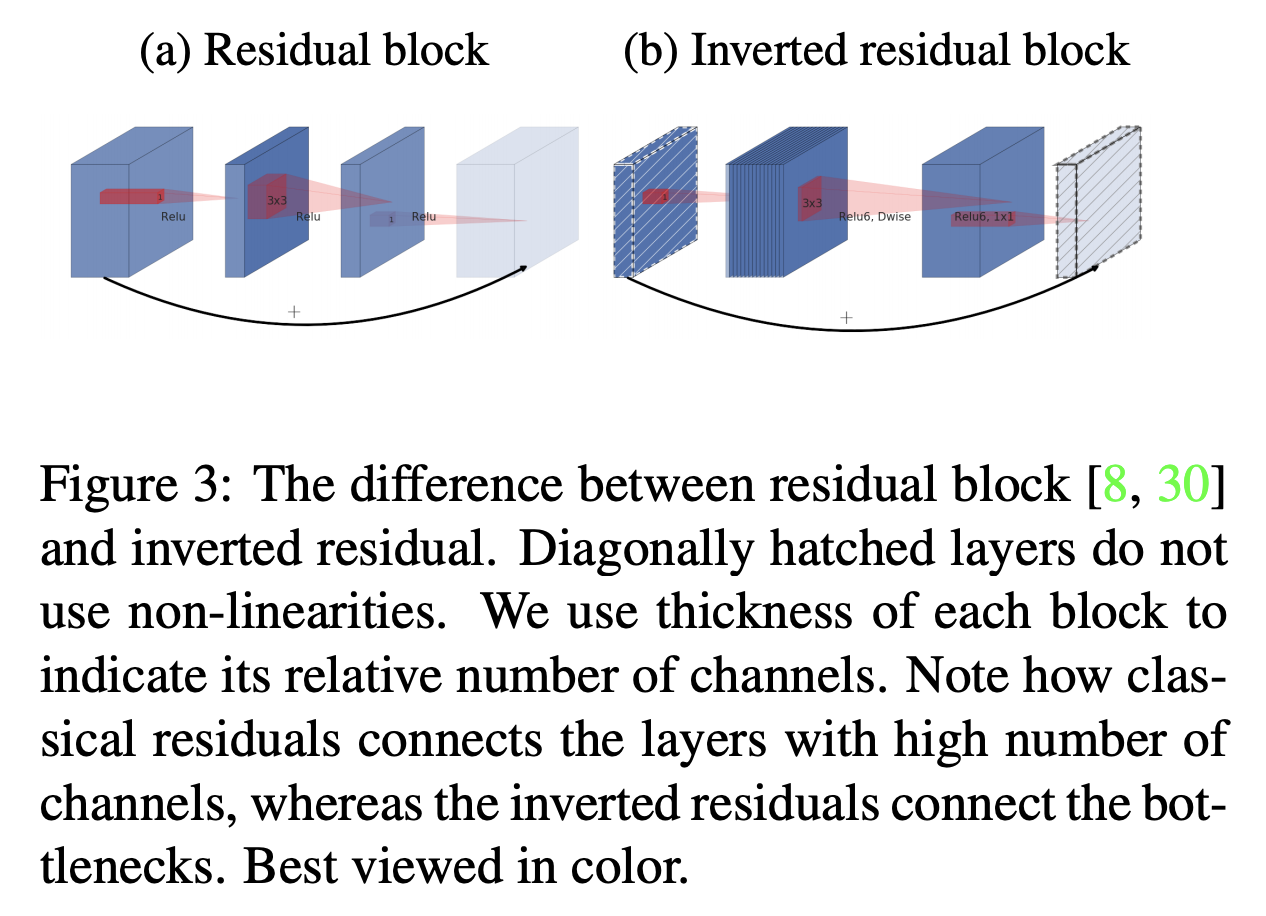

## Stochastic Depth

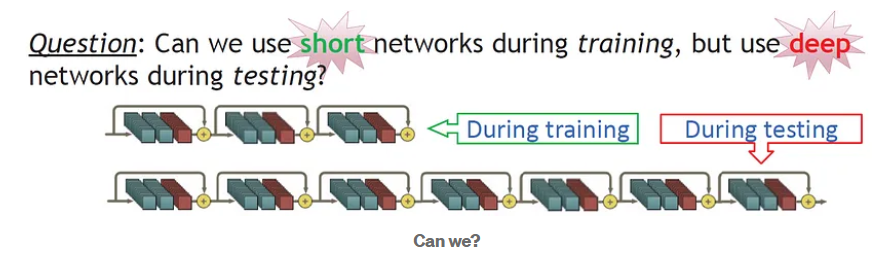

## SiLU (Swish 1), an activation function

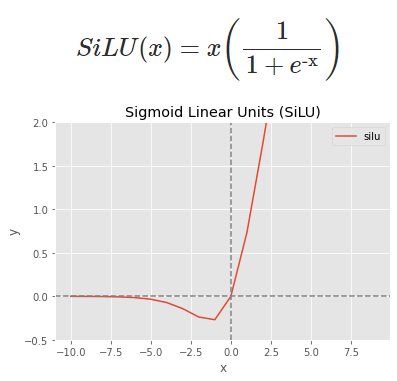

In [ ]:
from keras.applications import EfficientNetB0
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers

In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 128

In [ ]:
model = EfficientNetB0(include_top=False, weights='imagenet')


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
dataset_name = "food101"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "validation"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

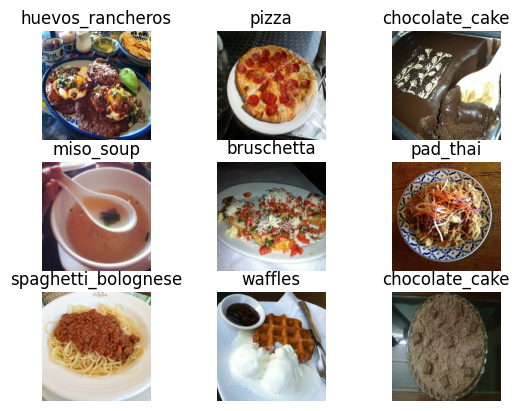

In [ ]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label

label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

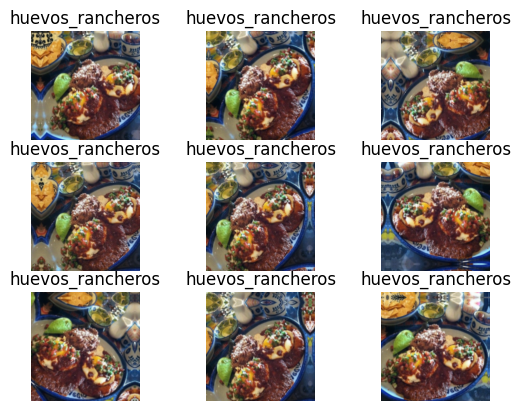

In [ ]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [ ]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

Epoch 1/25
591/591 [==============================] - 839s 1s/step - loss: 2.3208 - accuracy: 0.4741 - val_loss: 1.2861 - val_accuracy: 0.6498
Epoch 2/25
591/591 [==============================] - 824s 1s/step - loss: 1.7836 - accuracy: 0.5464 - val_loss: 1.2440 - val_accuracy: 0.6574
Epoch 3/25
591/591 [==============================] - 823s 1s/step - loss: 1.7497 - accuracy: 0.5557 - val_loss: 1.2216 - val_accuracy: 0.6664
Epoch 4/25
591/591 [==============================] - 808s 1s/step - loss: 1.7303 - accuracy: 0.5598 - val_loss: 1.2219 - val_accuracy: 0.6668
Epoch 5/25
591/591 [==============================] - 807s 1s/step - loss: 1.7257 - accuracy: 0.5607 - val_loss: 1.2582 - val_accuracy: 0.6609
Epoch 6/25
320/591 [===============>..............] - ETA: 5:47 - loss: 1.7230 - accuracy: 0.5627